# DCGAN on Bricks Dataset

In [1]:
import os
from PIL import Image

import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as Transforms

from matplotlib import pyplot as plt

from torchsummary import summary

## 0. Train Parameters

In [2]:
DATA_DIR = '../../data/Lego/dataset'
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

## 1. Prepare dataset

In [3]:
class LegoData(Dataset):

    def __init__(self, image_dir):
        super().__init__()
        self.image_dir = image_dir
        self.imgs = os.listdir(self.image_dir)
        self.length = len(self.imgs)

        # Define transforms
        self.transform = Transforms.Compose([
                            Transforms.ToTensor(),
                            Transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=None),
                            Transforms.Grayscale(num_output_channels=1)
        ])

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        img_file = os.path.join(self.image_dir, self.imgs[index])
        img = Image.open(img_file)
        img = self.transform(img)
        return img

In [4]:
def get_dataloader():
    lego_dataset = LegoData(DATA_DIR)
    train_loader = DataLoader(lego_dataset, batch_size=BATCH_SIZE, num_workers=8,
                              shuffle=True, pin_memory=True)
    return train_loader

torch.Size([128, 1, 64, 64])


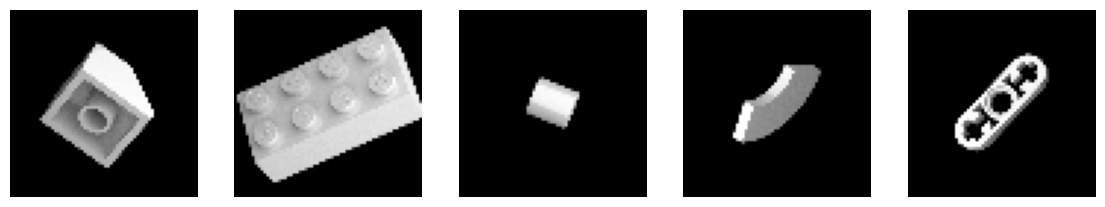

In [5]:
# Check dataset
train_loader = get_dataloader()
check_sample = next(iter(train_loader))
print(check_sample.shape)

plt.figure(figsize=(14, 3))
for i in range(5):
    ax = plt.subplot(1, 5, i+1)
    ax.imshow(check_sample[i][0], cmap='gray')
    ax.axis('off')

plt.show()

## 2. Building GAN

In [6]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        channel_list = [CHANNELS, 64, 128, 256, 512]
        
        # Convolutional layers
        self.conv_layers = nn.Sequential()
        for i in range(len(channel_list) - 1):
            conv_block = self.get_conv_block(channel_list[i], channel_list[i+1], bool(i))
            self.conv_layers.add_module(f'conv_block_{i}', conv_block)

        # Layers for the output -> (Batch_size, 1)
        self.output_layers = nn.Sequential(
            nn.Conv2d(in_channels=channel_list[-1], out_channels=1, 
                      kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.output_layers(x)
        return x    

    def get_conv_block(self, in_ch, out_ch, use_bn=False):
        conv_layer = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=4,
                               stride=2, padding=1, bias=False)
        batch_norm = nn.BatchNorm2d(num_features=out_ch, momentum=0.1) # Note: Keras and PyTorch use momentum in different ways
        leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        dropout_2d = nn.Dropout2d(p=0.3)
        
        conv_block = [conv_layer, batch_norm, leaky_relu, dropout_2d] if use_bn else [conv_layer, leaky_relu, dropout_2d] 
        return nn.Sequential(*conv_block)

# test = Discriminator().to(DEVICE)
# summary(test, (1, 64, 64))

In [7]:
class Generator(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        channel_list = [z_dim, 512, 256, 128, 64]

        # Convolution transpose layers
        self.trans_conv_layers = nn.Sequential()
        for i in range(len(channel_list) - 1):
            stride = 2 if i else 1
            padding = 1 if i else 0
            trans_conv_block = self.get_transpose_conv_block(channel_list[i], channel_list[i + 1],
                                                             stride, padding)
            self.trans_conv_layers.add_module(f'trans_conv_block_{i}', trans_conv_block)

        # Output layers -> (-1, 1, 64, 64)
        self.output_layers = nn.Sequential(
                nn.ConvTranspose2d(in_channels=channel_list[-1], out_channels=CHANNELS,
                                   kernel_size=4, stride=2, padding=1, bias=False),
                nn.Tanh()
        )


    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[-1], 1, 1)
        x = self.trans_conv_layers(x)
        x = self.output_layers(x)
        return x

    
    def get_transpose_conv_block(self, in_ch, out_ch, stride=2, padding=1):
        transpose_conv = nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch,
                                            kernel_size=4, stride=stride, padding=padding, bias=False)
        batch_norm = nn.BatchNorm2d(num_features=out_ch, momentum=0.1)
        leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        return nn.Sequential(transpose_conv, batch_norm, leaky_relu)

# generator = Generator(Z_DIM).to(DEVICE)
# summary(generator, (100,))

In [14]:
class DCGAN(nn.Module):
    
    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.generator = Generator(z_dim)
        self.discriminator = Discriminator()


    def forward(self, real_imgs):
        latents = torch.randn(size=(BATCH_SIZE, self.z_dim)).to(DEVICE)
        generated_imgs = self.generator(latents)

        real_preds = self.discriminator(real_imgs)
        fake_preds = self.discriminator(generated_imgs)

        real_labels = torch.ones_like(real_preds)
        fake_labels = torch.zeros_like(fake_preds)
        return real_preds, fake_preds, real_labels, fake_labels, generated_imgs

dcgan = DCGAN(Z_DIM).to(DEVICE)
summary(dcgan, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
         LeakyReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
         LeakyReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        LeakyReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 64, 64]           1,024
             Tanh-14            [-1, 1,